# Project 01: Tidal Forces on an Asteroid
**Name:** Maddox Schaller

## Introduction

**Overview:**

This project looks at the system of an asteroid and a planet—Jupiter, specifically—focussing on the tidal forces experienced by the asteroid. The simulation will track the motion of the asteroid as it comes near Jupiter, keeping track of the tidal forces which, if over a certain threshold, will cause it to fracture into smaller pieces. These pieces will also be kept track of throughout the similation, having the possibility of fracturing further. The pieces also have the possibility of colliding with the planet.

**Research Question:**

How does the number of fractures and number of collisions with the planet vary depending on the initial trajectory of the asteroid?

**Assumptions:**

- The asteroid is carbonaceous (C-type), a perfect sphere of radius 2 km (on the smaller end of C-type comets in the solar system), and it is of uniform density (of $1.38 g/cm^3$, the average of C-type asteroids)$^1$.
- Before coming near Jupiter, the asteroid has a speed of 20 km/s, around the average speed of asteroids in the solar system$^2$
- The gravitational acceleration of the asteroid on Jupiter is negligible, being on the order of $10^{13}$ times smaller than that of Jupiter on the comet (given that Jupiter is ~$10^{13}$ times more massive than the asteroid)
    - As such, Jupiter is considered to be motionless in the simulation
- The asteroid breaks into to evenly sized (and thus equally massive) pieces when tidal forces reach their threshold
    - For simplicity, these pieces are also modelled as spheres, and are placed such that they are not overlapping
- Since the system is symmetric, I will only consider positive angles, as negative angles would yield symmetrical results

**A Closer Look at the Simulation:**

Past research has found that the tensile strength of asteroids of the size and density we are considering is ~300 Pa$^1$. To find an estimate of the total force that the asteroid, or one of its fragments, could withstand (i.e. the threshold for the tidal force), we can simply multiply the tensile strength by the largest cross-sectional area of the asteroid/fragment:

$$F_{breakpoint} = \sigma \cdot A = \sigma \cdot \pi r^2$$

Since we assume that the asteroid is breaking into two smaller spheres of the same density, we find that it has a new radius of

$$V_{new} = \frac{1}{2} V_{prev} \quad \Rightarrow \quad 4/3 \pi r_{new}^3 = 2/3 \pi r_{prev}^3 \quad \Rightarrow \quad r_{new} = \left(\frac{1}{2} r_{prev}^3 \right)^{\frac{1}{3}} = \left(\frac{1}{2} \right)^{\frac{1}{3}} r_{prev}$$

To vary the trajectory of the comet, the program takes an input $\theta$, the angle between the direction of Jupiter and the velocity vector, and uses this to calculate the x- and y-components of velocity. An RK4 algorithm is then used to calculate the new position and velocity of the asteroid/fragments at each time step, while the Newtonian gravitation equation $\left( F = \frac{GMm}{r^2} \right)$ is used to calculate the new acceleration, as well as the tidal force at each position. 

As discussed earlier, when the tidal force exceeds the "breakpoint force," the simulation splits the asteroid or fragment into two, smaller fragments. To handle this, it first adds the defining characteristics of the two new fragments to the set of lists defining all of the fragments, each with a smaller radius (as defined above), half the mass, the same velocity, a slightly offset position (with one closer to Jupiter and the other further), and a new acceleration defined by their new position. The simulation also moves the object that was fractured to a separate list, such that the simulation does not continue tracking its motion (since we now only want to track the motion on the fragments).

The results of the simulation can then be plotted visually, showing the trajectories, or we can just extract the key information, such as the number of fractures and collisions.

## The Simulation

The following code cell creates functions that calculate the simulation, and can plot its results

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
dt = 5 # s
tmax = 200000 # s
steps = int(tmax / dt) # Total number of steps
G = 6.6743e-11

# Object 1 (Jupiter)
R = 69911000 # m
M = 1.898e27 # kg
xi1 = 0 # m
yi1 = 0 # m

# Other objects
r = [2000] # m
rho = 1380 # kg/m^3
sigma = 300 # Tensile strength [Pa]
m = [4/3 * np.pi * r[0]**3 * rho] # kg
xi2 = 0 # m
yi2 = 30000000000 # m

v = 20000 # m/s

# implement the rk4 algorithm
def rk4(state, dt, G, M, m, r):
    
    # get acceleration from position
    def derivatives(x, y, vx, vy):
        dx = -x
        dy = -y
        d = (dx**2 + dy**2)**0.5
        Fi = G * M * m / d**2
        Fxi = Fi * dx / d
        Fyi = Fi * dy / d
        ax = Fxi / m
        ay = Fyi / m
        return vx, vy, ax, ay

    x2, y2, vx, vy, ax, ay, t, Ftidal = state

    # Calculate k1 values
    k1_vx, k1_vy, k1_ax, k1_ay = derivatives(x2, y2, vx, vy)
    k1_x = vx * dt
    k1_y = vy * dt

    # Calculate k2 values
    k2_vx, k2_vy, k2_ax, k2_ay = derivatives(x2 + 0.5 * k1_x, y2 + 0.5 * k1_y, vx + 0.5 * k1_ax * dt, vy + 0.5 * k1_ay * dt)
    k2_x = (vx + 0.5 * k1_ax * dt) * dt
    k2_y = (vy + 0.5 * k1_ay * dt) * dt

    # Calculate k3 values
    k3_vx, k3_vy, k3_ax, k3_ay = derivatives(x2 + 0.5 * k2_x, y2 + 0.5 * k2_y, vx + 0.5 * k2_ax * dt, vy + 0.5 * k2_ay * dt)
    k3_x = (vx + 0.5 * k2_ax * dt) * dt
    k3_y = (vy + 0.5 * k2_ay * dt) * dt

    # Calculate k4 values
    k4_vx, k4_vy, k4_ax, k4_ay = derivatives(x2 + k3_x, y2 + k3_y, vx + k3_ax * dt, vy + k3_ay * dt)
    k4_x = (vx + k3_ax * dt) * dt
    k4_y = (vy + k3_ay * dt) * dt

    # Update position and velocity 
    x2_new = x2 + (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
    y2_new = y2 + (k1_y + 2 * k2_y + 2 * k3_y + k4_y) / 6
    vx_new = vx + (k1_ax + 2 * k2_ax + 2 * k3_ax + k4_ax) / 6 * dt
    vy_new = vy + (k1_ay + 2 * k2_ay + 2 * k3_ay + k4_ay) / 6 * dt

    # Update time
    t_new = t + dt
    
    # Calculate tidal force for the new distance
    d_new = (x2_new**2 + y2_new**2)**0.5
    Fclose = G * M * m / (d_new - r)**2
    Ffar = G * M * m / (d_new + r)**2
    Ftidal_new = Fclose - Ffar
    
    return x2_new, y2_new, vx_new, vy_new, k4_ax, k4_ay, t_new, Ftidal_new

def trajectory(angle):
    
    # Constants
    dt = 5 # s
    tmax = 2000000 # s
    steps = int(tmax / dt) # Total number of steps
    G = 6.6743e-11

    # Object 1 (Jupiter)
    R = 69911000 # m
    M = 1.898e27 # kg
    xi1 = 0 # m
    yi1 = 0 # m

    # Other objects
    r = [2000] # m
    rho = 1380 # kg/m^3
    sigma = 300 # Tensile strength [Pa]
    m = [4/3 * np.pi * r[0]**3 * rho] # kg
    xi2 = 0 # m
    yi2 = 30000000000 # m

    v = 20000 # m/s

    # find x and y velocities
    theta = angle*(2*np.pi)/360
    vxi = v * np.sin(theta)
    vyi = -v * np.cos(theta)
    
    # Calculating acceleration on object 2
    dxi = xi1-xi2
    dyi = yi1-yi2
    d = ((dxi)**2+(dyi)**2)**(1/2)
    Fi = G*M*m[0]/d**2
    Fxi = Fi*dxi/d
    axi = Fxi/m[0]
    Fyi = Fi*dyi/d
    ayi = Fyi/m[0]

    # Calculating Tidal forces
    Fclose =  G*M*m[0]/(d-r[0])**2
    Ffar = G*M*m[0]/(d+r[0])**2
    Ftidal = Fclose - Ffar

    sigma = 300 # Tensile strength [Pa]

    MaxForce = sigma * np.pi * r[0]**2 # calculate max force
    
    # Create a list of all variables we want to keep track of 
    t = [0.]
    x2 = [[xi2]] 
    y2 = [[yi2]]
    vx = [[vxi]]
    vy = [[vyi]]
    ax = [[axi]]
    ay = [[ayi]]
    
    Ftidal = 0

    x2_postbreak = [] 
    y2_postbreak = []
    vx_postbreak = []
    vy_postbreak = []
    ax_postbreak = []
    ay_postbreak = []
    t_postbreak = []

    # Keep track of the number of collisions, fractures, and revolutions
    num_collisions = 0
    num_fractures = 0
    first_fracture = None # this is for the appendix 
    num_revolutions = 0 # this is just so that the program will stop itself after one orbit
    
    # loop over all times
    for i in range(steps):
        #loop over all objects
        for j in range(len(x2)):

            state = x2[j][-1], y2[j][-1], vx[j][-1], vy[j][-1], ax[j][-1], ay[j][-1], t[-1], Ftidal # define the old state
            
            x2_new,y2_new,vx_new,vy_new,ax_new,ay_new,t_new, Ftidal_new = rk4(state, dt, G, M, m[j], r[j]) # calculate the new state
            
            # Append updated quantities to their lists
            x2[j].append(x2_new)
            y2[j].append(y2_new)
            vx[j].append(vx_new)
            vy[j].append(vy_new)
            ax[j].append(ax_new)
            ay[j].append(ay_new)
            t.append(t_new)
            
            Ftidal = Ftidal_new
            
            # Test for collision with the planet
            
            d = (x2[j][-1]**2 + y2[j][-1]**2)**(1/2)
            
            if d <= R+r[j]:

                num_collisions += 1

                x2_postbreak.append(x2[j])
                y2_postbreak.append(y2[j])
                del r[j]
                del m[j]
                del x2[j]
                del y2[j]
                del vx[j]
                del vy[j]
                del ax[j]
                del ay[j]
                break
                
            # Test if the meteor enters orbit
            if x2[j][-2] > 0 and x2[j][-1] < 0 or x2[j][-2] < 0 and x2[j][-1] > 0:
                
                num_revolutions += 1
                
                if num_revolutions > len(2*x2):
                
                    x2_postbreak.append(x2[j])
                    y2_postbreak.append(y2[j])
                    del r[j]
                    del m[j]
                    del x2[j]
                    del y2[j]
                    del vx[j]
                    del vy[j]
                    del ax[j]
                    del ay[j]
                    break

            # test if a fracture occurs
            
            MaxForce = sigma * np.pi * r[j]**2
            
            if Ftidal >= MaxForce:
                
                num_fractures += 1
                
                if num_fractures == 1:
                    first_fracture = d
                
                # move the fractured object to a separate list
                x2_postbreak.extend([x2[j]])
                y2_postbreak.extend([y2[j]])
                vx_postbreak.extend([vx[j]])
                vy_postbreak.extend([vy[j]])
                ax_postbreak.extend([ax[j]])
                ay_postbreak.extend([ay[j]])
                t_postbreak.extend(t)

                # add new fragments, and remove the old fragment
                r.extend([r[j]*(1/2)**(1/3)]*2)
                del r[j]
                m.extend([m[j]/2]*2)
                del m[j]

                x2.extend([[x2_new-r[-1]*-x2_new/d]]) 
                x2.extend([[x2_new+r[-1]*-x2_new/d]])
                del x2[j]
                y2.extend([[y2_new-r[-1]*-y2_new/d]])
                y2.extend([[y2_new+r[-1]*-y2_new/d]])
                del y2[j]
                vx.extend(2*[[vx_new]])
                del vx[j]
                vy.extend(2*[[vy_new]])
                del vy[j]
                ax.extend([[G*M*x2[-2][0]/(((x2[-2][0])**2 + (y2[-2][0])**2)**(1/2))**3]])
                ax.extend([[G*M*x2[-1][0]/(((x2[-1][0])**2 + (y2[-1][0])**2)**(1/2))**3]])
                del ax[j]
                ay.extend([[G*M*y2[-2][0]/(((x2[-2][0])**2 + (y2[-2][0])**2)**(1/2))**3]])
                ay.extend([[G*M*y2[-1][0]/(((x2[-1][0])**2 + (y2[-1][0])**2)**(1/2))**3]])
                del ay[j]
                
    return x2, y2, x2_postbreak, y2_postbreak, num_collisions, num_fractures, first_fracture

def plotting(angle):
    x2, y2, x2_postbreak, y2_postbreak, num_collisions, num_fractures, _ = trajectory(angles[k])
    
    print(f"{angle}° trajectory: {num_fractures} fractures and {num_collisions} collisions") # print the numerical results of the simulation

    # Make Plots
    for j in range(len(x2_postbreak)):
        axe[k, 0].plot(x2_postbreak[j],y2_postbreak[j],"--", label=f"Comet trajectory {j+1}")

    for j in range(len(x2)):
        axe[k, 0].plot(x2[j],y2[j],"--", label=f"Comet trajectory")

    # Create data for a circle
    alpha = np.linspace(0, 2 * np.pi, 100)
    x = R * np.cos(alpha)
    y = R * np.sin(alpha)

    # Plot the circle
    axe[k, 0].plot(x, y, color='red')  # Circle outline
    axe[k, 0].fill(x, y, color='red', alpha=0.5, label="planet")  # Filled circle

    axe[k, 0].set_xlim(-2e+10, 2e+10)
    axe[k, 0].set_ylim(-2e+10, 2e+10)
    axe[k, 0].set_xlabel("x [m]")
    axe[k, 0].set_ylabel("y [m]")
    axe[k, 0].set_title(f"Angle = {angles[k]}°", fontsize=11)

    for j in range(len(x2_postbreak)):
        axe[k, 1].plot(x2_postbreak[j],y2_postbreak[j],"--", label=f"Comet trajectory {j+1}")

    for j in range(len(x2)):
        axe[k, 1].plot(x2[j],y2[j],"--", label=f"Comet trajectory")

    # Create data for a circle
    alpha = np.linspace(0, 2 * np.pi, 100)
    x = R * np.cos(alpha)
    y = R * np.sin(alpha)

    # Plot the circle
    axe[k, 1].plot(x, y, color='red')  # Circle outline
    axe[k, 1].fill(x, y, color='red', alpha=0.5, label="planet")  # Filled circle

    axe[k, 1].set_xlim(-5e+8, 5e+8)
    axe[k, 1].set_ylim(-5e+8, 5e+8)
    axe[k, 1].set_xlabel("x [m]")
    axe[k, 1].set_ylabel("y [m]")
    axe[k, 1].set_title(f"Angle = {angles[k]}°", fontsize=11)

### A visualization of the simulation

Now that we have created the simulation, I will start by plotting a few representative scenarios of the apporach of the asteroid, each at a slightly varied angle:

0.535° trajectory: 255 fractures and 256 collisions
0.54° trajectory: 255 fractures and 27 collisions
0.545° trajectory: 255 fractures and 0 collisions
0.7° trajectory: 15 fractures and 0 collisions
0.9° trajectory: 0 fractures and 0 collisions


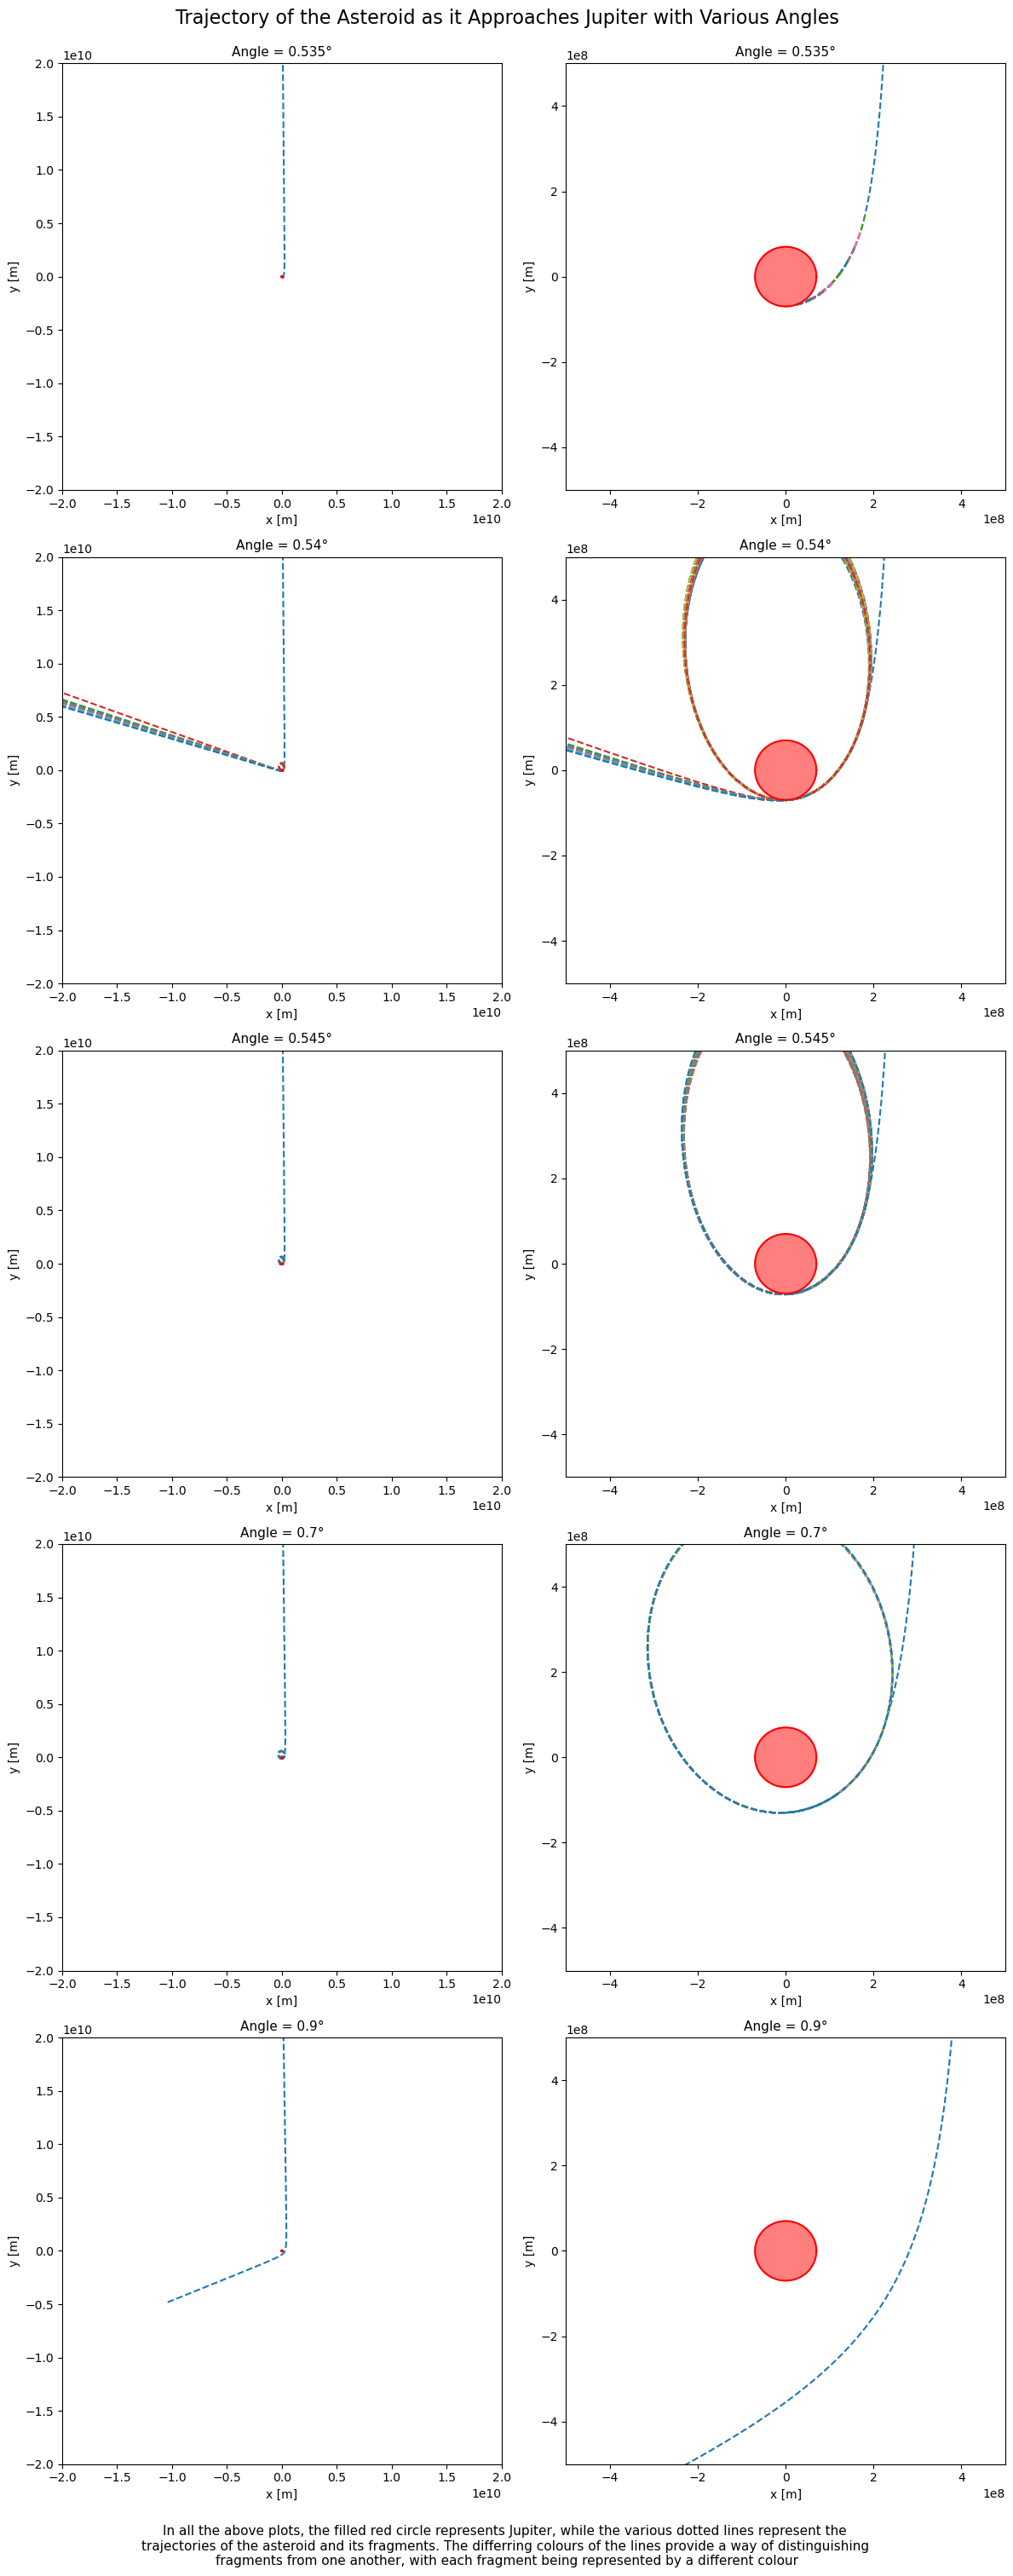

In [5]:
angles = [0.535, 0.54, 0.545, 0.7, 0.9] # define the angles

fig, axe = plt.subplots(len(angles), 2, figsize=(12,6*len(angles))) # initialize plot

fig.suptitle("Trajectory of the Asteroid as it Approaches Jupiter with Various Angles", fontsize=16)

# plot at different angles 
for k in range(len(angles)):
    plotting(angles[k])

fig.text(0.5, -0.02, "In all the above plots, the filled red circle represents Jupiter, while the various dotted lines represent the \n" 
                    "trajectories of the asteroid and its fragments. The differring colours of the lines provide a way of distinguishing \n"
                    "fragments from one another, with each fragment being represented by a different colour", 
         ha='center', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.983])
plt.show()

For the 0.535° trajectory, we see a situation in which the asteroid fractures a total of 255 times (meaning there is a maximum of 256 objects, since we start with 1). We also notice that every single one of these objects collides with jupiter. From this, we can infer that the maximum number of fractures that could be found in this simulation is 255. This is because the fracturing radius (the distance between the center of jupiter and the center of the asteroid at the time of fracture) is uniquely determined by the fragments' mass and radius, since all other relavent values are constant. This implies that for each fragment, there is a specific threshold distance where a fracture would occur, but if each of the 256 fragments collided with Jupiter before splitting again, then the next threshold distance must be completely within jupiter, and thus could never be reached with any inital angle.

For the 0.54° trajectory, we see what is probably the most interesting set of trajectories. First, by just looking at the numbers, we see that there are 255 fractures, like the previous angle, but there are only 27 collisions, meaning some fragments collided with Jupiter while others did not. Now turning our focus to the plot itself, we can see why this may be: all the fragments appear to at least pass very close to the planet, meaning the subtle differences in positions of the fragments led to some but not all of them colliding with the planet. Additionally, we see that for the fragments that don't collide with Jupiter, there are two general trajectories that they follow: some get caught in orbit while others appear to fly off, not being gravitationally bound to the planet. This is quite unexpected: since all fragments originate from a single asteroid, and since we expect energy to be conserved, how can we have some fragments being bound and others escaping the planet's gravity? The answer to this is more thoroughly discussed in appendix 1.3, but generally, it's due to the imprecision of using stepwise integration. Luckily, for the sake of this investigation, there is no important difference between these two trajectories (as they both result from a fragment not colliding with Jupiter). As such, for the rest of the investigation, I will not be treating them as different.

Moving onto the angle 0.545°, we see a scenario where the asteroid fractures its maximum possible number of times—255—but there are no collisions with Jupiter. Here, it's also worth taking note of the fact the difference between the angle where every fragment collided with Jupiter (0.535°), and this angle (0.545°), where no fragments hit the planet, is very, very small, being only a difference of 0.01°. This indicates that later, when we are more closely comparing the number of fractures and collisions, we may have to look very closely at this range of angles.

Looking at the last initial angles, we see that for the 0.7° trajectory, there were 15 breaks and no collisions, while for the 0.9° trajectory, no breaks nor collisions occured. Unlike the first three trajcetories, here we can notice that the inital angle can change a fair amount more without leading to any macroscopic change in the results of the simulation (such as the number of fractures).

### A comparison of the number of fractures and collisions at various angles

After having seen visually what the simulation does, we can now take a closer look at how the initial trajectory of the asteroid can affect the number of fractures and collisions. To do this, I will be creating a multi-pannel plot that demonstrates the behaviour at: (1) a wide range of angles, (2) a smaller range of angles that focuses on the change in the number of fractures, and (3) a very narrow range of angles that focusses on the change in the number of collisions.

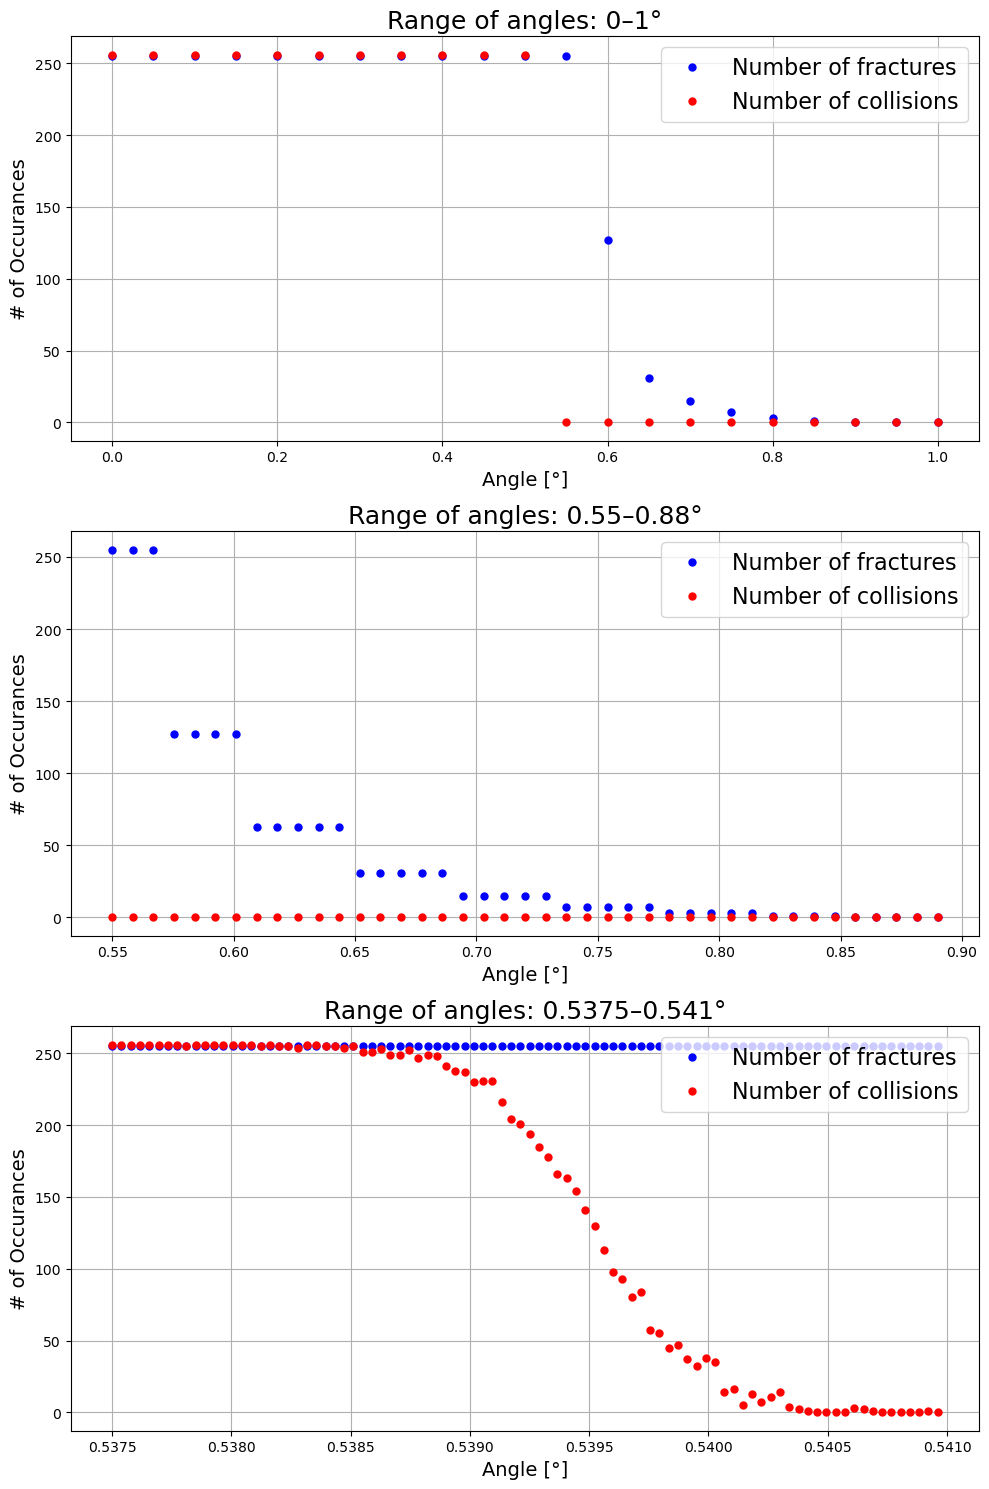

In [12]:
# defining the angles of interest

angles1 = [0.05*i for i in range(21)]
collisions1 = []
fractures1 = []

angles2 = [0.55 + 0.0085*i for i in range(41)]
collisions2 = []
fractures2 = []

angles3 = [0.5375 + 0.00003888888889*i for i in range (90)]
collisions3 = []
fractures3 = []

# calculating the number of fractures and collisions from each set of angles

for a in angles1:
    result = trajectory(a) # saving all the results separately
    collisions1 += [result[4]] # pulls values from results instead of running trajectories multiple times
    fractures1 += [result[5]]

for a in angles2:
    result = trajectory(a) 
    collisions2 += [result[4]]
    fractures2 += [result[5]]
    
for a in angles3:
    result = trajectory(a) 
    collisions3 += [result[4]] 
    fractures3 += [result[5]]

# making the plots for each set of angles
    
fig, axe = plt.subplots(3, 1, figsize=(10, 15)) #initialize plot

axe[0].plot(angles1, fractures1, marker='o', linestyle='None', markersize=5, color='blue', label='Number of fractures')
axe[0].plot(angles1, collisions1, marker='o', linestyle='None', markersize=5, color='red', label='Number of collisions')

axe[0].set_xlabel('Angle [°]', fontsize=14)
axe[0].set_ylabel('# of Occurances', fontsize=14)
axe[0].set_title(f"Range of angles: 0–1°", fontsize=18)
axe[0].grid()
axe[0].legend(fontsize=16, loc='upper right')

axe[1].plot(angles2, fractures2, marker='o', linestyle='None', markersize=5, color='blue', label='Number of fractures')
axe[1].plot(angles2, collisions2, marker='o', linestyle='None', markersize=5, color='red', label='Number of collisions')

axe[1].set_xlabel('Angle [°]', fontsize=14)
axe[1].set_ylabel('# of Occurances', fontsize=14)
axe[1].set_title(f"Range of angles: 0.55–0.88°", fontsize=18)
axe[1].grid()
axe[1].legend(fontsize=16, loc='upper right')

axe[2].plot(angles3, fractures3, marker='o', linestyle='None', markersize=5, color='blue', label='Number of fractures')
axe[2].plot(angles3, collisions3, marker='o', linestyle='None', markersize=5, color='red', label='Number of collisions')

axe[2].set_xlabel('Angle [°]', fontsize=14)
axe[2].set_ylabel('# of Occurances', fontsize=14)
axe[2].set_title(f"Range of angles: 0.5375–0.541°", fontsize=18)
axe[2].grid()
axe[2].legend(fontsize=16, loc='upper right')

plt.tight_layout()
plt.show()


Just looking at the first graph, showing results for angles from 0–1°, we can't get very much information. We do see that from angles of ~0-0.5°, both the number of fractures and number of collisions are at their maximum (255 and 256, respectively), and that from ~0.9-1°, they are both at their minimum (0). Looking back to what we saw when looking at the trajectories, this makes sense—we know that at an angle of 0.535°, we had 255 fractures and 256 collisions, while at 0.9°, there were 0 fractures and 0 collisions; it is then easy to see why any angle from 0-0.5° would have the same numbers as 0.535° (as the trajectory is more head on), while any angle 0.9-1° would have the same results as 0.9° (as the asteroid would pass further from the planet). Lastly, we see that both number of fractures and collisions drop rapidly, with the fractures decreasing over the range from 0.55-0.9°, so this is the region that we focus on in the second graph.

Looking at the reduced range of angles in the second graph (0.55-0.9°), we can notice a couple of things. First, it seems as though the number of fractures does not decrease linearly, insteading decreasing by a large interval, then plateauing briefly, then decreasing by another large interval, etc., until the minimum is reached. This can be explained by the fact that the fragments of the asteroid are quite close together throughout their trajectories (which can be seen in the overlapping lines in the previous section, where they were visualized), while there are very specific thresholds for when breaks occur. This means that in the case of the vast majority of trajectories, either all fragments will pass the threshold, or none will, which leads to the plateaus and jumps seen on the graph.

In the third and final graph, we look at a very narrow range of values (0.5375-0.541°) in order to see how the number of collisions changes depending on the initial angle. Now, instead of seeing a steep dropoff as we did in the first two graphs, we see an overall gradual decrease, though not one that is paritcularly steady, as we notice that there are sometimes quicks drops or even increases in the number of fractures as the angle increases. This inconsistency is probably just due to some of the assumptions made for the simulation, as in real life, we would expect for this graph to be strictly decreasing.

### Conclusion

To give a brief summary of the results, it was found that a maximum number of 255 fractures and 256 collisions occured for any positive initial angle below ~0.56°, while there was a minimum of 0 and 0 for angles above ~0.9°. 

We then found that the number of fractures varied over angles from ~0.56-0.9°, with the change being far from linear, instead having rapid declines alternating with plateaus.

Finally, we found that the number of collisions varied over a very small range of initial angles: ~0.5375-0.541°. Unlike the number of fractures, though, it's decrease was quite gradual, slowly decreasing from its maximum to its minimum.

## References
_(In addition to citations for any python packages used beyond our standard ones, list the sources for any data or literature cited in your project. Additionally, you must also cite the sources for any code that you found on the internet or from peers.)_

1. https://en.wikipedia.org/wiki/Standard_asteroid_physical_characteristics#:~:text=Krasinsky%20et%20al.,and%205.32%20g%2Fcm3.

2. https://studyfy.com/blog/what-is-the-average-asteroid-speed

3. https://www.lpi.usra.edu/meetings/lpsc2002/pdf/1444.pdf

4. https://en.wikipedia.org/wiki/Roche_limit

## Appendix 1: Code validation

### A1.1: Comparison of simulation results with by-hand calculations

To verify that the asteroid is fracturing at the expected distance from the planet, I will be calculating by hand when this would occur. I will just be doing this for the initial asteroid, and not its post-fracture fragments, as if the simulation is accurate for the first fracture, it should remain accurate for all following fractures (since the code loops)

To begin, I will derive a generalized formula for the fracturing distance:

$$F_{breakpoint} = F_{tidal}$$


$$\sigma \pi r_{fragment}^2 = F_{close} - F_{far} = \frac{GMm}{(d_{breakpoint} - r_{fragment})^2} - \frac{GMm}{(d_{breakpoint} + r_{fragment})^2} $$


$$\sigma \pi r_{fragment}^2 = GMm \left( \frac{1}{(d_{breakpoint} - r_{fragment})^2} - \frac{1}{(d_{breakpoint} + r_{fragment})^2} \right) = GMm \left( \frac{(d_{breakpoint}+r_{fragment})^2 - (d_{breakpoint}-r_{fragment})^2}{(d_{breakpoint}^2 - r_{fragment}^2)^2} \right)$$


$$(d_{breakpoint}^2 - r_{fragment}^2)^2 = \frac{GMm}{\sigma \pi r_{fragment}^2} \left( (d_{breakpoint}+r_{fragment})^2 - (d_{breakpoint}-r_{fragment})^2 \right) = \frac{GMm}{\sigma \pi r_{fragment}^2} (4d_{breakpoint}r_{fragment})$$


$$d_{breakpoint}^4 - 2d_{breakpoint}^2r_{fragment}^2 + r_{fragment}^4 = \frac{GMm}{\sigma \pi r_{fragment}^2} (4d_{breakpoint}r_{fragment})$$

$$d_{breakpoint}^4 - 2d_{breakpoint}^2r_{fragment}^2 + r_{fragment}^4 = \frac{GMm}{\sigma \pi r_{fragment}} (4d_{breakpoint})$$

As seen above, we obtain a quartic equation for $d_{breakpoint}$, which can be very difficult to solve analytically. As such, I will using an online numerical solver (WolfRamAlpha) to find the breakpoint.

To calculate the breakpoint for the initial asteroid, we have the following constants: $G = 6.67 \cdot 10^{-11} \; \frac{N\cdot m^2}{kg^2}$, $M = 1.898 \cdot 10^{27} \; kg$, $\sigma = 300 \; Pa$, $r_{fragment} = 2000 \; meters$, $m = 4.624 \cdot 10^{13} \; kg$. Plugging the equation, along with all the constants above, into WolfRamAlpha results in a value of $2.316 \cdot 10^{8} \; m$.

Now we can compared this to what we find in the simulation:

In [30]:
print(f"The first breakpoint found is: {trajectory(0)[6]:.3e} m")

The first breakpoint found is: 2.316e+08 m


We find that the simulation almost perfectly lines up with what we caluclated. 

### A1.2: Comparison to the Roche Limit

The Roche limit is a mathematically derived formula that tries to predict the point at which an orbiting body will be pulled apart by tidal forces, first calculatedby French astronomer Édouard Roche in the mid 19th century$^4$. There are multiple (allbeit similar) variations of the formula that all give the same results, but for our purposes, the following will be the easiest to use:

$$d = r \left( 2 \frac{M}{m} \right) ^{\frac{1}{3}}$$

Plugging in the values for our system ($r_{fragment} = 2000 \; meters$, $M = 1.898 \cdot 10^{27} \; kg$, $m = 4.624 \cdot 10^{13} \; kg$):

$$d = 2000 \; meters \; \left( 2 \frac{1.898 \cdot 10^{27} \; kg}{4.624 \cdot 10^{13} \; kg} \right) ^{\frac{1}{3}} = 8.69 \cdot 10^7 \; meters$$

This means that the Roche limit predicts that the asteroid will begin to fracture at a distance slightly less than 40% closer to Jupiter than was found in this simulation. The reason for this discrepancy most likely has to do with the assumptions made in my simulation—I assumed that the asteroid would split perfectly down its center, and that its tensile strength was the same everywhere. Instead, an asteroid would have differing tensile strength throughout it, which would also most likely prevent it from fracturing into two perfectly equal pieces.

### A1.3: Debugging

The following is a previous iteration of my code:

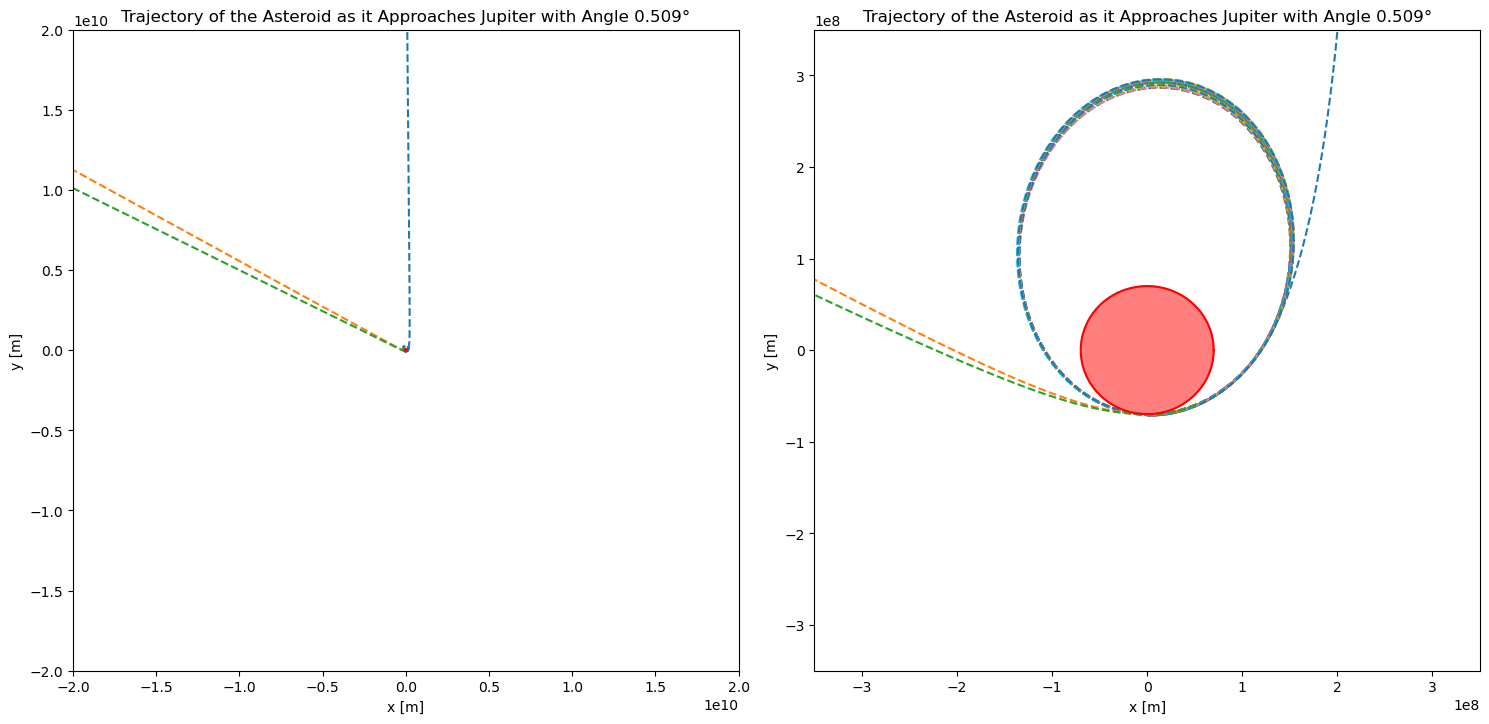

In [31]:
import numpy as np
import matplotlib.pyplot as plt

angles = [0.509] 

# Initializing the subpolt
fig, axe = plt.subplots(1, 2, figsize=(15,7.5*len(angles)))

for k in range(len(angles)):
    
    # Constants
    dt = 10 # s
    tmax = 2000000 # s
    steps = int(tmax / dt) # Total number of steps
    G = 6.6743e-11

    # Object 1 (Jupiter)
    R = 69911000 # m
    M = 1.898e27 # kg
    xi1 = 0 # m
    yi1 = 0 # m

    # Other objects
    r = [1000] # m
    rho = 1380 # kg/m^3
    m = [4/3 * np.pi * r[0]**3 * rho] # kg
    xi2 = 0 # m
    yi2 = 30000000000 # m

    v = 20000 # m/s

    theta = angles[k]*(2*np.pi)/360
    vxi = v * np.sin(theta)
    vyi = -v * np.cos(theta)

    # Calculating acceleration on object 2
    dxi = xi1-xi2
    dyi = yi1-yi2
    d = ((dxi)**2+(dyi)**2)**(1/2)
    Fi = G*M*m[0]/d**2
    Fxi = Fi*dxi/d
    axi = Fxi/m[0]
    Fyi = Fi*dyi/d
    ayi = Fyi/m[0]

    # Calculating Tidal forces
    Fclose =  G*M*m[0]/(d-r[0])**2
    Ffar = G*M*m[0]/(d+r[0])**2
    Ftidal = Fclose - Ffar

    sigma = 300 # Tensile strength [Pa]

    MaxForce = sigma * np.pi * r[0]**2

    # Create a list foc all variables we want to keep track of (time list was created earlier)
    t = [0.]
    x2 = [[xi2]] 
    y2 = [[yi2]]
    vx = [[vxi]]
    vy = [[vyi]]
    ax = [[axi]]
    ay = [[ayi]]

    x2_postbreak = [] 
    y2_postbreak = []
    vx_postbreak = []
    vy_postbreak = []
    ax_postbreak = []
    ay_postbreak = []
    t_postbreak = []

    # Keep track of the number of collisions, fractures, and revolutions
    num_collisions = 0
    num_fractures = 0
    num_revolutions = 0

    for i in range(steps):
        for j in range(len(x2)):

            # Retrieve the position, velocity, acceleration, and time from the previous iteration
            x2_last = x2[j][-1]
            y2_last = y2[j][-1]
            vx_last = vx[j][-1]
            vy_last = vy[j][-1]
            ax_last = ax[j][-1]
            ay_last = ay[j][-1]
            t_last = t[-1]

            # Calculate new physical quantities
            x2_new = x2_last + vx_last * dt
            y2_new = y2_last + vy_last * dt
            vx_new = vx_last + ax_last * dt
            vy_new = vy_last + ay_last * dt

            dx = xi1-x2_new
            dy = yi1-y2_new
            d = np.sqrt((dx)**2+(dy)**2)
            Fi = G*M*m[j]/d**2
            Fxi = Fi*dx/d
            ax_new = Fxi/m[j]
            Fyi = Fi*dy/d
            ay_new = Fyi/m[j]

            # Calculating Tidal forces
            Fclose = G*M*m[j]/(d-r[j])**2
            Ffar = G*M*m[j]/(d+r[j])**2
            Ftidal = Fclose - Ffar
            
            t_new = t_last + dt

            # Append updated quantities to their lists
            x2[j].append(x2_new)
            y2[j].append(y2_new)
            vx[j].append(vx_new)
            vy[j].append(vy_new)
            ax[j].append(ax_new)
            ay[j].append(ay_new)
            t.append(t_new)

            # Test for collision with the planet
            if d <= R:

                num_collisions += 1

                # print("collision!")
                x2_postbreak.append(x2[j])
                y2_postbreak.append(y2[j])
                del r[j]
                del m[j]
                del x2[j]
                del y2[j]
                del vx[j]
                del vy[j]
                del ax[j]
                del ay[j]
                break
                
            # Test if the meteor enters orbit
            if x2_last > 0 and x2_new < 0:
                
                num_revolutions += 1
                
                if num_revolutions > len(x2):
                    
                    x2_postbreak.append(x2[j])
                    y2_postbreak.append(y2[j])
                    del r[j]
                    del m[j]
                    del x2[j]
                    del y2[j]
                    del vx[j]
                    del vy[j]
                    del ax[j]
                    del ay[j]
                    break

            MaxForce = sigma * np.pi * r[j]**2

            if Ftidal >= MaxForce:

                num_fractures += 1

                x2_postbreak.extend([x2[j]])
                y2_postbreak.extend([y2[j]])
                vx_postbreak.extend([vx[j]])
                vy_postbreak.extend([vy[j]])
                ax_postbreak.extend([ax[j]])
                ay_postbreak.extend([ay[j]])
                t_postbreak.extend(t)

                r.extend([r[j]*(1/2)**(1/3)]*2)
                del r[j]
                m.extend([m[j]/2]*2)
                del m[j]

                x2.extend([[x2[j][-1]-r[-1]*dx/d]]) # NEED TO PLACE THEM AT SLIGHTLY DIFFERENT LOCATIONS
                x2.extend([[x2[j][-1]+r[-1]*dx/d]])
                del x2[j]
                y2.extend([[y2[j][-1]-r[-1]*dy/d]])
                y2.extend([[y2[j][-1]+r[-1]*dy/d]])
                del y2[j]
                vx.extend(2*[[vx[j][-1]]])
                del vx[j]
                vy.extend(2*[[vy[j][-1]]])
                del vy[j]
                ax.extend(2*[[G*M*x2[-2][0]/(((x2[-2][0])**2 + (y2[-2][0])**2)**(1/2))**3]])
                del ax[j]
                ay.extend(2*[[G*M*y2[-2][0]/(((x2[-2][0])**2 + (y2[-2][0])**2)**(1/2))**3]])
                del ay[j]
    
    for j in range(len(x2_postbreak)):
        axe[0].plot(x2_postbreak[j],y2_postbreak[j],"--", label=f"Comet trajectory {j+1}")
    
    for j in range(len(x2)):
        axe[0].plot(x2[j],y2[j],"--", label=f"Comet trajectory")

    # Create data for a circle
    alpha = np.linspace(0, 2 * np.pi, 100)
    x = R * np.cos(alpha)
    y = R * np.sin(alpha)

    # Plot the circle
    axe[0].plot(x, y, color='red')  # Circle outline
    axe[0].fill(x, y, color='red', alpha=0.5, label="planet")  # Filled circle
    
    axe[0].set_xlim(-2e+10, 2e+10)
    axe[0].set_ylim(-2e+10, 2e+10)
    axe[0].set_xlabel("x [m]")
    axe[0].set_ylabel("y [m]")
    axe[0].set_title(f"Trajectory of the Asteroid as it Approaches Jupiter with Angle {angles[k]}°")
    
    for j in range(len(x2_postbreak)):
        axe[1].plot(x2_postbreak[j],y2_postbreak[j],"--", label=f"Comet trajectory {j+1}")
    
    for j in range(len(x2)):
        axe[1].plot(x2[j],y2[j],"--", label=f"Comet trajectory")

    # Create data for a circle
    alpha = np.linspace(0, 2 * np.pi, 100)
    x = R * np.cos(alpha)
    y = R * np.sin(alpha)

    # Plot the circle
    axe[1].plot(x, y, color='red')  # Circle outline
    axe[1].fill(x, y, color='red', alpha=0.5, label="planet")  # Filled circle

    axe[1].set_xlim(-3.5e+8, 3.5e+8)
    axe[1].set_ylim(-3.5e+8, 3.5e+8)
    axe[1].set_xlabel("x [m]")
    axe[1].set_ylabel("y [m]")
    axe[1].set_title(f"Trajectory of the Asteroid as it Approaches Jupiter with Angle {angles[k]}°")

# Display the plots
plt.tight_layout()
plt.show()

The issue with the code above may not be immediately obvious—everything seems to be executing properly—but there is something in the result of the simulation that does not make sense physically. What this is, is that here, there are some fragments of the asteroid being caught by the planet's gravity and entering orbit, while there are also some fragments avoiding orbit, flying off to infinity.

This is a problem because we expect none of the fragments of the asteroid to enter the orbit of Jupiter. Looking at the initial state of the asteroid, it is at a distance of $3 \cdot 10^{10} \; m$ from the center of Jupiter, traveling at a speed of $20 \; km/s$. Calculating the escape velocity of the asteroid at this position, we have:

$$v_{esc} = \sqrt{\frac{2GM}{r}} = \sqrt{\frac{2 \cdot 6.67 \cdot 10^{-11} \cdot 1.898 \cdot 10^{27}}{3 \cdot 10^{10}}} = 2.905 \; km/s$$

The escape velocity is far lower than the initial velocity of the asteroid, meaning the asteroid is not initially gravitationally bound to planet, and since velocity is conserved through the fractures, we expect that the total energy of the system should stay roughly constant (i.e. constant enough for no fragment to get trapped in the gravitational field of Jupiter). 

However, it is clear that since some of the asteroid fragments are getting caught in orbit, energy is not, in fact, being conserved. After spending some hours trying to find any error in the logic or calculations of the program, I found nothing wrong, suggesting that the problem had to do with the euler method being used, as it is not always energy conserving. To solve this, I tried implementing various other algorithms, including RK4, Verlet-velocity, and Leapfrog, but none of these seemed to change the fact that the total energy of the system would change throughout time.

After the time that I have spent trying to resolve this issue, I believe that given the constaints of this project (requiring a simulation that uses stepwise integration), there is no way for me to create a simulation that is properly energy conserving. However, despite this flaw, I am still able to answer my research quesiton—although the error in the simulation leads to trajectories that are not fully realistic, the calculations of tidal forces function properly, and the comparisons between number of fractures and collisions remain unaffected by the lack of energy conservation. All that the simulation truly needs to do is to keep count of the number of fractures and the number of collisions, which is it still able to accomplish.

## Appendix 2: Reflection questions

### Reflection 1: Coding Approaches (A)
*(How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.)*

- I feel as though I did a very good job applying what we learned in class, as well as extending the coding, and this mostly has to do with the fact that I faced a difficult challenge when it came to debugging
    - I spoke with great detail about both this challenge in appendix 1.3, so I wont go into more detail here, but I will note that this process of debugging and implementing new algorithms is where I learned the most while working on this project, even if it did not lead to a solution to the issue

### Reflection 2: Coding Approaches (B)
*(Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.)*

- I think a specific aspect of my code that I did particularly well was my use of compound lists to store the state of the fragments of the asteroid
    - In particular, I am proud of the logic I used to ensure that the correct fragments were being tracked, as opposed to the old fragments that had already split. At the start of my work on this project, it was not immediately obvious how I should do this, and it was very rewarding to figure out something that worked
- Something I wish I spent more time and effort on was the optimization of the simulation. Especially towards the end of the project, some of the code cells take a very long time to run, so having spent some effort trying to decrease this run time may have been a good idea

### Reflection 3: Simulation phyiscs and investigation (A)
*(How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.)*

- I think I did well in choosing to investigate a concept in physics that I did not know very much about prior to the project, and finding a way to implement it in a decently realistic scenario, leading to a project where I feel I've actually learned something real, rather than something abstract
- Additionally, I think I did a pretty good job at exploring the phase space I chose, taking a close look at all of the angles of interest

### Reflection 4: Simulation phyiscs and investigation (B)
*(Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.)*

- I think something I did particularly well was determining the threshold force that the asteroid could withstand, as to do this I needed to do some research, investigating the tensile strength of the specific type of asteroid I was considering
- Something more I feel I could've done is extending the phase space that I was considering. For example, I could have looked at what happens with different sizes of asteroids.

### Reflection 5: Effectiveness of your communication
*(Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.)*

- One part of my communication I think I did well with was explaining the reasons why I chose to set up the simulation the way I did, and doing calculations to justify my code
- Something I feel as though I could have done better with is the display of my graphs. Although I am able to communicate my point with the plots I have, having more detailed and more varied plots may have given more insight into my simulation